# Feature Engineering 2
In this notebook, we describe the third step of our feature engineering approach, where we use the discrete cosine transform (DCT) to further reduce the dimensionality of our feature vector.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/feature_engineering_2.ipynb)

In [1]:
random_state = 42

In [2]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets


# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
#...and download raw data if not already downloaded
from data_utils import init_data
init_data(syn_data_path=SYN_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import get_anomaly_scoring
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv)
from bench_utils import (
    classification_benchmark,
    repeat_experiment,
    aabb_classification_benchmark,
    extract_metrics)
from data_utils import (load_processed_data,
                        load_syn_reg_data,
                        FEATURE_LIST)
from LogFilterbank import LogFilterbank
from manifold_utils import tsne_embedding
from feature_utils import extract_dctc

time passed: 5.87 s
downloading synthetic data successful: True


## Filterbank Configuration

In [4]:
# configuration
sr = 120000 #originally from df['kHz'].iloc[-1]*1000*2 # from measurement, highest f[kHz]*2
n_log_bins = 66
n_fft = 1600
n_fft_bins = 801
f_min = 1300
f_max = 24000
norm = 'height'

fb = LogFilterbank(sr=sr, n_fft_bins=n_fft_bins, n_log_bins=n_log_bins, f_min=f_min, f_max=f_max, norm=norm)

## Loading Data

In [5]:
to_dB = True

from pathlib import Path
file_names = list(SYN_DATA_PATH.glob('**/*.csv'))

# cache file for faster data loading on later iterations
pickle_name = Path(SYN_DATA_PATH, f"filtered_specs__fmin_{fb.f_min}__fmax_{fb.f_max}__lbins_{fb.n_log_bins}.pkl")
pickle_name

PosixPath('../data/synthetic/filtered_specs__fmin_1300__fmax_24000__lbins_66.pkl')

In [6]:
%%time

target_col = 'y_radius'

df = load_processed_data(file_names, fb, y_col=[target_col], to_dB=to_dB, cache_file=pickle_name)

CPU times: user 6.65 ms, sys: 3.4 ms, total: 10 ms
Wall time: 8.23 ms


In [7]:
df = df.sort_values(by=target_col) # make sure the class labels are sorted for further convenience

## DCT for dimensionality reduction

In [8]:
X = df[df.columns[0:fb.n_log_bins]].values

n_coeffs = 32
X_dct = extract_dctc(X=X, n_coeffs=n_coeffs)

## Scaling
Due to the properties of DCT, scaling is not as important anymore, and we can do just fine without it.

## Classwise Feature Distribution

In [9]:
plot_df = pd.DataFrame(X_dct)
plot_df[target_col] = df[target_col]

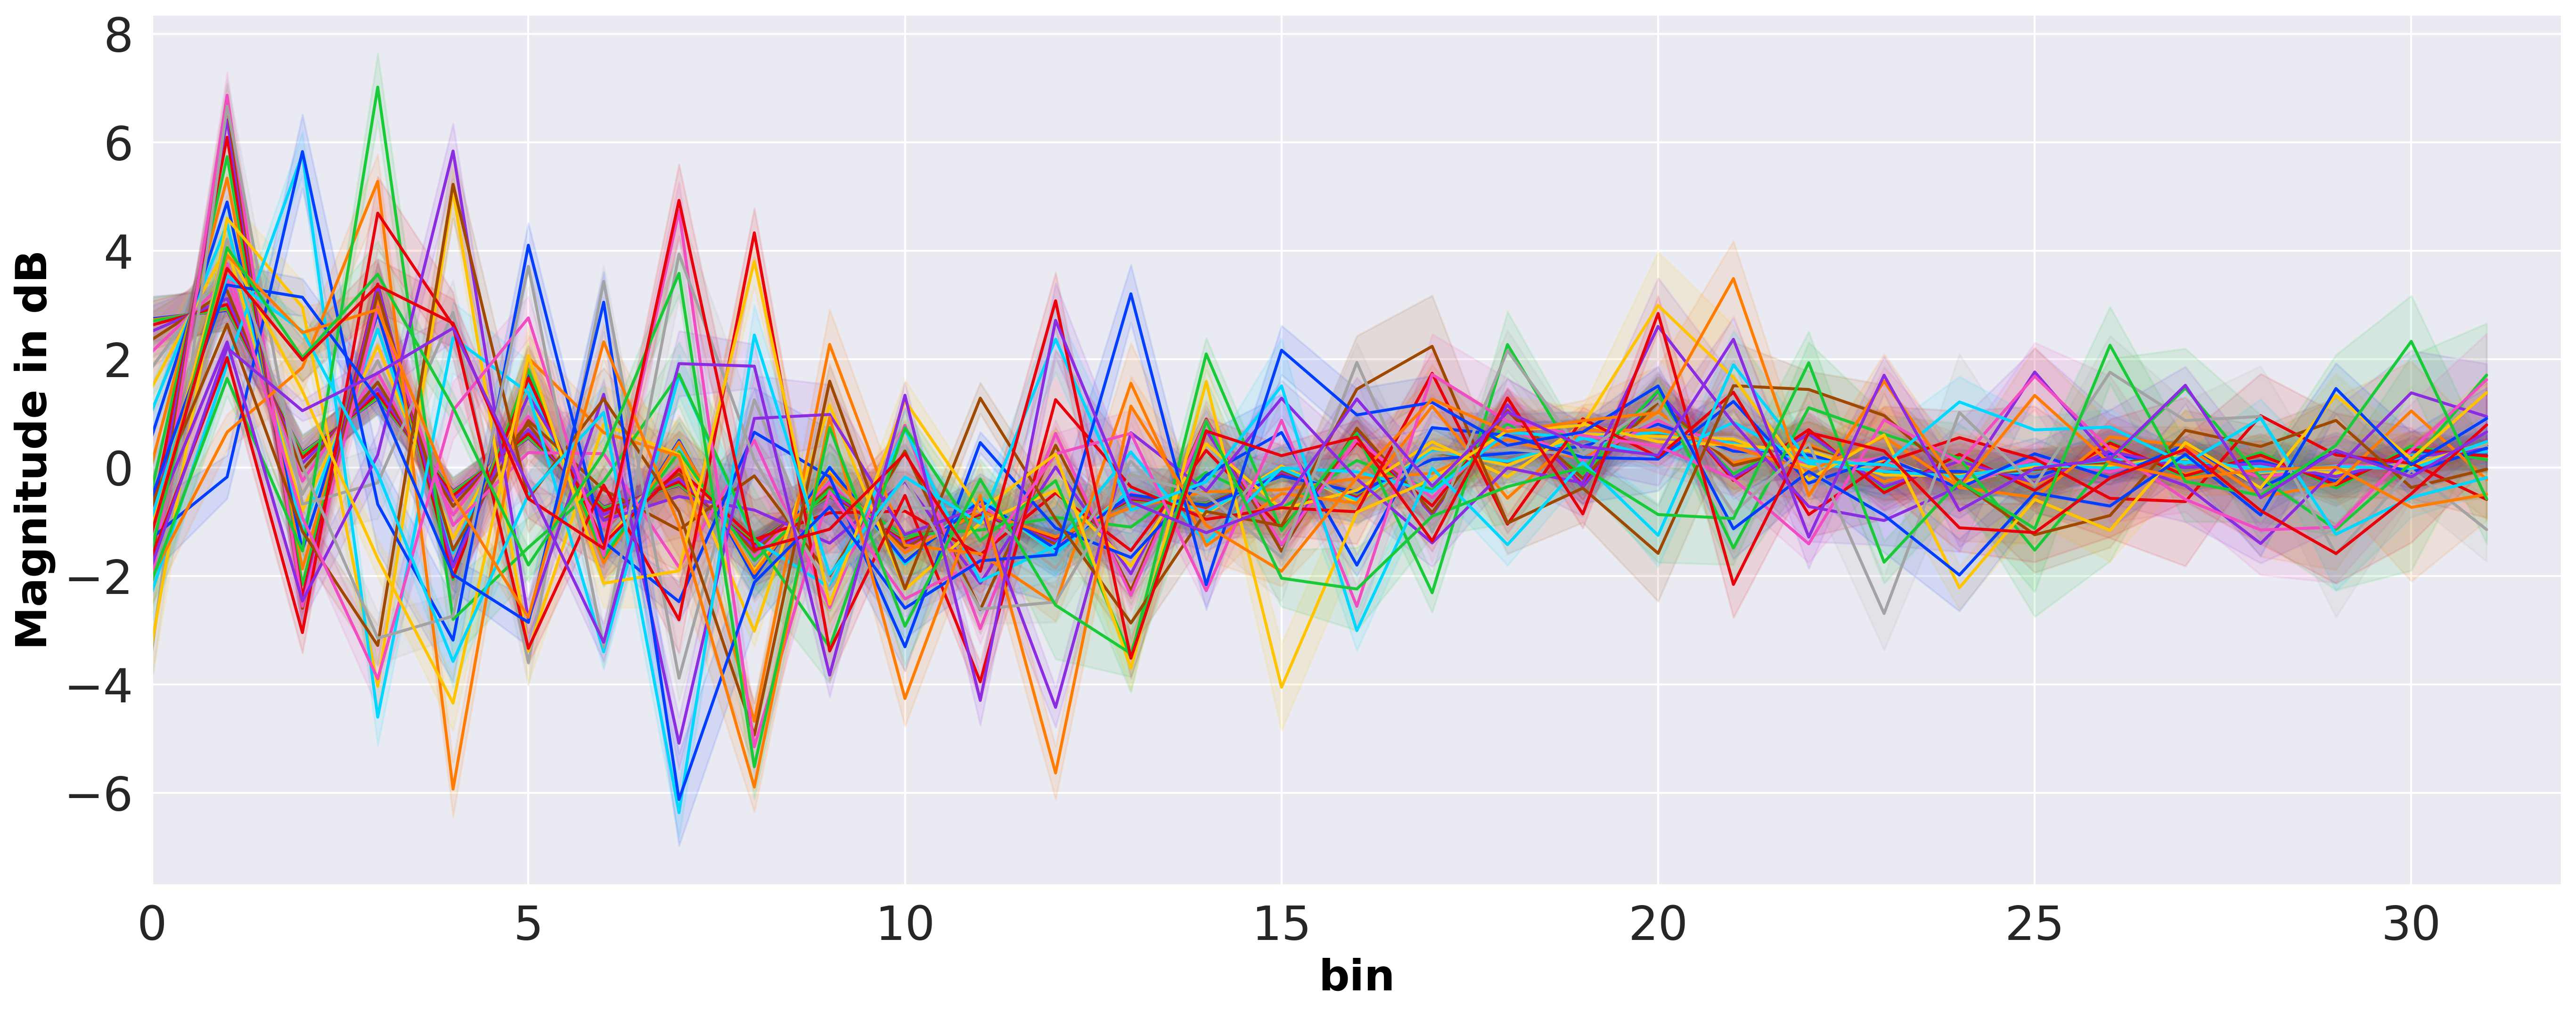

In [10]:
from matplotlib.ticker import FormatStrFormatter

axis_font = {#'family': 'Times',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }

num_features = len(plot_df.columns)-1

fig = plot_classwise_dist(df=plot_df, label_col=target_col)

fig.gca().get_legend().remove()

fig.gca().set_xlabel("bin", fontdict=axis_font)
fig.gca().set_ylabel("Magnitude in dB", fontdict=axis_font)

fig.get_axes()[0].set(xlim=(0, num_features))

plt.show()

## Classwise Individual Feature Distribution

In [11]:
cntr = Counter(plot_df[target_col])
labels = list(cntr.keys())
palette = sns.color_palette("bright", len(cntr.keys()))

In [12]:
feature_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(plot_df.columns)-2,
    step=1,
    description='feature:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='100%')
)


focus_slider = widgets.IntSlider(
    value=-1,
    min=-1,
    max=len(cntr.keys())-1,
    step=1,
    description='target focus:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='100%')
)


def plot_feature_kde(df, label_col, labels, palette=None, feature_idx=0, focus=-1):
    fig = plot_classwise_kde(df=df, label_col=label_col, labels=labels,
                             palette=palette, feature_idx=feature_idx,
                             focus=focus)
    plt.title("Use the sliders above to explore the distributions of each feature wrt. damage radius")
    fig.gca().legend(ncol=5, loc='best', title="$\\bf{Damage\:Radius\:in\:mm}$", title_fontsize=18, fontsize=18);
    
    
widgets.interact(plot_feature_kde,
                 df=widgets.fixed(plot_df),
                 label_col=widgets.fixed(target_col),
                 labels=widgets.fixed(labels),
                 palette=widgets.fixed(palette),
                 feature_idx=feature_slider,
                 focus=focus_slider);

interactive(children=(IntSlider(value=0, continuous_update=False, description='feature:', layout=Layout(width=…

## Explore T-SNE embedding

In [13]:
X_embedded = tsne_embedding(X=X_dct, perplexity=25)

X_embedded.shape

(34152, 2)

In [14]:
df_embedded = pd.DataFrame(X_embedded, columns=['x', 'y'])
df_embedded[target_col] = np.copy(df[target_col].values)

df_embedded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         34152 non-null  float32
 1   y         34152 non-null  float32
 2   y_radius  34152 non-null  float32
dtypes: float32(3)
memory usage: 400.3 KB


In [15]:
# predefine palette to keep it from changing after thresholding changes the number of classes to be mapped, hence ever changing the palette
palette = dict(zip(cntr.keys(), sns.color_palette(palette="bright", n_colors=len(cntr.keys()))))
palette.update({-1: "k"})

In [16]:
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')


def embedding_widget(df, label_col, thresh=0., palette=palette):
    y = np.copy(df[label_col].values)
    y[y<thresh] = -1
        
    X = df.drop(columns=[label_col]).values
    
    fig = plot_embedding_targets(X, y, alpha=0.2, palette=palette)
    plt.title("Use the slider above to collaps damage radii below thresh into a sinlge class (black)")
    fig.set_size_inches((15, 11))
    legend = plt.legend(ncol=7, loc="lower center", title_fontsize=16, fontsize=16)
    legend.set_title("$\\bf{Damage\:Radius\:in\:mm}$")

    plt.ylim(-200, 120)
    plt.xlim(-120, 120)
    plt.xticks([])
    plt.yticks([]);

thresh_slider = widgets.FloatSlider(
    value=0.,
    min=0.0,
    max=40,
    step=0.01,
    description='thresh:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout=widgets.Layout(width='90%')
)

widgets.interact(embedding_widget,
                 df=widgets.fixed(df_embedded),
                 label_col=widgets.fixed(target_col),
                 thresh=thresh_slider,
                 palette=widgets.fixed(palette));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='thresh:', layout=Layout(wid…